In [1]:
# from TL import preproc_TL 
%matplotlib inline 
import matplotlib.pyplot as plt
from prep_data import Dataset 
from torch.utils.data import DataLoader
from LSTM_Net import LSTM_Net
import torch.nn as nn 
import torch 
import numpy as np
import math 
import gc
import time 
from skimage.transform import resize
import sys
sys.path.append("../")
from util import * 
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# fed the seed for reproducibility 

In [2]:
torch.backends.cudnn.deterministic = True
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)



## Global variable 

In [3]:
# data paths and parameters
data_path = '../LSTM_Otway_submitted_v2/data'
base_path = f"{data_path}/base_otw.npy" 
mon_path = f"{data_path}/mon_otw.npy" 
Mclean_path  = f"{data_path}/mon_otw_c.npy"


# Net path 
# net = './Network/LSTM_Otway.pth'    
epoch=25
# net = f'./Network/LSTM_Otway_epc{epoch}.pth'



parm = {
 'nt': 1250,
 'ng': 605,
 'ns': 121,
 'dt': 0.002,
 'dg': 0.004000000189989805,
 'ds': 1.0,
 'ot': 0.0,
 'og': 0.012000000104308128,
 'os': 0.0}


# Hyperparameters for training
batchsz = 64 
num_epochs = 300 
LR = 0.002
hsz = 51
act = 'tanh'
n_layer=2
bias= False
dropout = 0.




# define the window for plotting  
# start = 100
# last =  900 

# # define the overburden window 
start = 450
last =  650 

feature_leangth = 41


hyperpar = f"_lr{LR}_nlayer{n_layer}_act{act}_bias{bias}_batchsz{batchsz}_time_start{start}_end{last}"
net_path = "./Network/"
net = f'{net_path}LSTM_Otway_epc{epoch}{hyperpar}.pth'


last =  900 

batchsz = 1 

# -----------------------------------------------#
# RSF PATH 
# path = '/home/alaliaa/Time_lapse_ML/ML_Models2/data/'
# base = path + 'Base_data.rsf'
# mon = path + 'MonNoisy_data.rsf'

In [4]:

base = np.load(base_path)
mon = np.load(mon_path)
Mclean = np.load(Mclean_path)


ns,ng,nt = base.shape
print ('ns',ns,'ng',ng,'nt',nt)


# Take only few shots 
base = base[40:90:10,]
mon = mon[40:90:10,]
Mclean = Mclean[40:90:10,]
ns,ng,nt_ = base.shape

# # Take only few shots 
# base = base[30:50,]
# mon = mon[30:50,]
# Mclean = Mclean[30:50,]
# ns,ng,nt_ = base.shape


# base = base[50:70,]
# mon = mon[50:70,]
# Mclean = Mclean[50:70,]
# ns,ng,nt_ = base.shape

base = base.reshape((ns*ng,nt))
mon = mon.reshape((ns*ng,nt))
Mclean = Mclean.reshape((ns*ng,nt))

print('data shapeed to 2d',base.shape)






ns 120 ng 609 nt 1250
data shapeed to 2d (3045, 1250)


In [5]:
''' Pre Processing the data for trainign 
    - specify the infer time window 
    - scale the data 
    - Rolling window ??! 

'''


def scale_data(data=None):
    print('shape of data that will be scaled', data.shape)
    assert len(data.shape)==2
    ng,nt = data.shape  
    
    data = data.T
    scaler= MinMaxScaler(feature_range=(-1,1))
    # scaler= StandardScaler()
    scaler.fit(data)
    scaled_data = scaler.transform(data)
    scaled_data = scaled_data.T 


    return scaled_data,scaler
    return scaled_data,scaler
         

# The training part from the trace 
base = base[:,start:last]
mon = mon[:,start:last] 
Mclean = Mclean[:,start:last] 


# Scaling 
base, base_scaler = scale_data(base) 
mon , mon_scaler  = scale_data(mon) 


# move to torch 
base = torch.from_numpy(base).double()
mon  = torch.from_numpy(mon).double()





shape of data that will be scaled (3045, 450)
shape of data that will be scaled (3045, 450)


In [6]:
def window (x,dimension=-1,size=11,step=1):
    ''' x has to be pytorch tensor'''
    return x.unfold(dimension,size,step)


print(base.shape)
base_win =window(base,size=feature_leangth,step=1)
mon_win =window(mon,size=feature_leangth,step=1)[:,:,feature_leangth//2]
mon_win = mon_win.view(mon_win.shape[0],mon_win.shape[1],-1)


print(base_win.shape),print(mon_win.shape)


torch.Size([3045, 450])
torch.Size([3045, 410, 41])
torch.Size([3045, 410, 1])


(None, None)

In [7]:
# Load the mdoel 

model = LSTM_Net(input_size=base_win.shape[-1], hidden_layer_size=hsz, output_size=mon_win.shape[-1],
                batch_sz=batchsz,num_lstm_layer=n_layer,activation=act,dropout=0,bias=bias)
# model = LSTM_Net2(1,hsz,1,batchsz)
model.load_state_dict(torch.load(net))
model.cuda().double()
model.eval()



LSTM_Net(
  (lstm): LSTM(41, 51, num_layers=2, bias=False, batch_first=True)
  (linear): Linear(in_features=51, out_features=1, bias=False)
)

In [8]:
''' Main inference ''' 

Pred = torch.zeros_like(mon_win)
count = 0 
with torch.no_grad():
    for i in range (base_win.shape[0]//batchsz): 
        model.h_init()
        inp = base_win[count:count+batchsz,].cuda()
        Pred_batch = model(inp)
        Pred[count:count+batchsz,] = Pred_batch.detach().cpu()
        count += batchsz
# Pred = Pred.numpy()[:,:,0]
# mon = mon.detach().numpy()[:,:,0]
# base = base.detach().numpy()[:,:,0]


Pred = mon_scaler.inverse_transform(Pred[:,:,-1].T).T    

base = base_scaler.inverse_transform(base.T).T    
mon = mon_scaler.inverse_transform(mon.T).T    


In [9]:
mon.shape

(3045, 450)

In [10]:
B=base.reshape((ns,ng,last-start))[:,:,feature_leangth//2:-(feature_leangth//2)]
M=mon.reshape((ns,ng,last-start))[:,:,feature_leangth//2:-(feature_leangth//2)]
Mc = Mclean.reshape((ns,ng,last-start))[:,:,feature_leangth//2:-(feature_leangth//2)]
Pr = Pred.reshape((ns,ng,last-start-feature_leangth+1))


# base= B 
# mon = M
# Mclean = Mc
# Pred = Pr
 
# base = base[1*ng:2*ng,:]
# mon = mon[1*ng:2*ng,:]
# Mclean = Mclean[1*ng:2*ng,:]
# Pred = Pred[1*ng:2*ng,:]

In [11]:
# Metrics 

def RMS(a):
    N = a.shape[0]
    return np.sqrt(1/N * np.sum(a**2))
#     return np.sqrt(np.mean(a**2))

def NRMS (B,M,ti,tf):
    N = B.shape[0]
    b = B[:,ti:tf].copy()
    m = M[:,ti:tf].copy()
    num = RMS(b-m)
    den = RMS(b)+RMS(m)
    score = 200 * num/den
    return score
    
def phi(b,m):
    num = np.sum(b*m)
    den = np.sqrt(np.sum(b**2)*np.sum(m**2))
    return num/den
    
def predictability(B,M,ti,tf):
    N = B.shape[0]
    b = B[:,ti:tf].copy()
    m = M[:,ti:tf].copy()
    w = b.shape[-1]
    tao = 0
    num = 0 
    den = 0
    for tao in range(w//2): 
        phi_bm = phi(b[tao:tao+w//2],m[tao:tao+w//2])
        phi_bb = phi(b[tao:tao+w//2],b[tao:tao+w//2])
        phi_mm = phi(m[tao:tao+w//2],m[tao:tao+w//2])
        num   += phi_bm * phi_bm
        den   += phi_bb * phi_mm
    score = 100 * num/den
    return score


metric window is [0.9-1.31]
metric window is [0.9-1.31]
metric window is [0.9-1.31]
metric window is [0.9-1.31]


/tmp/ipykernel_2506/2698285185.py:20: RuntimeWarning: invalid value encountered in double_scalars
  return num/den


metric window is [0.9-1.31]


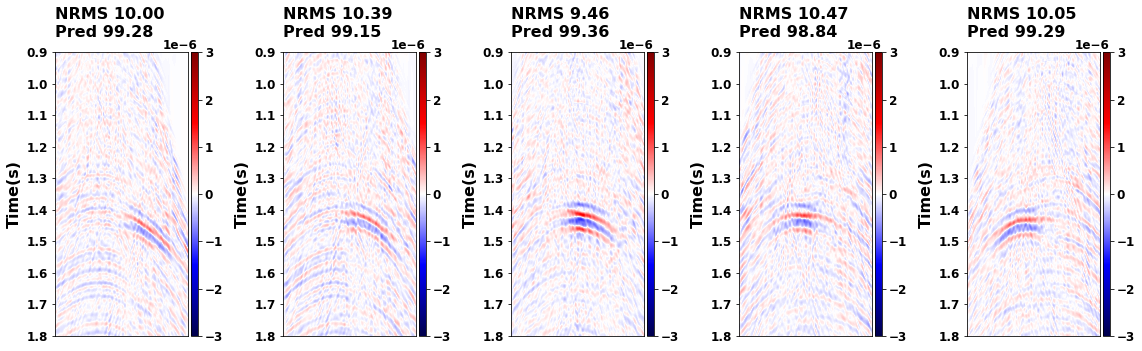

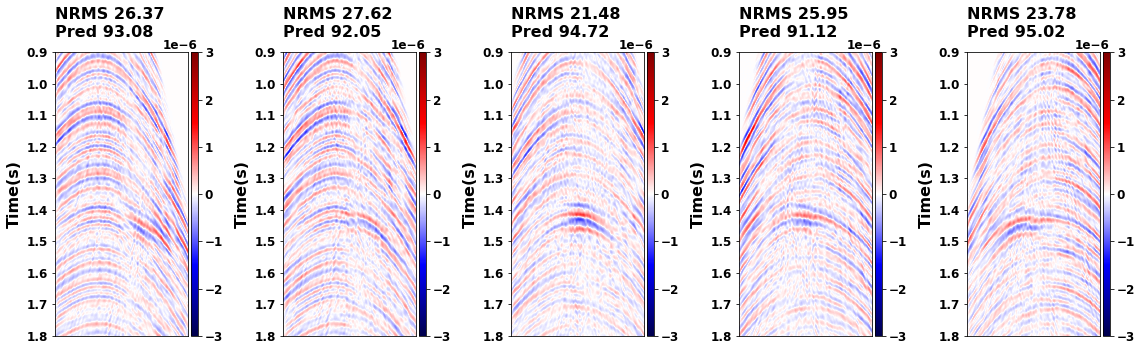

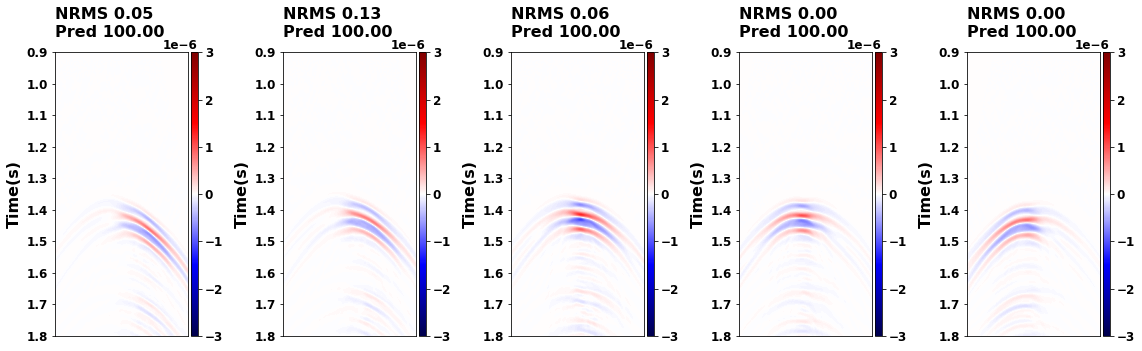

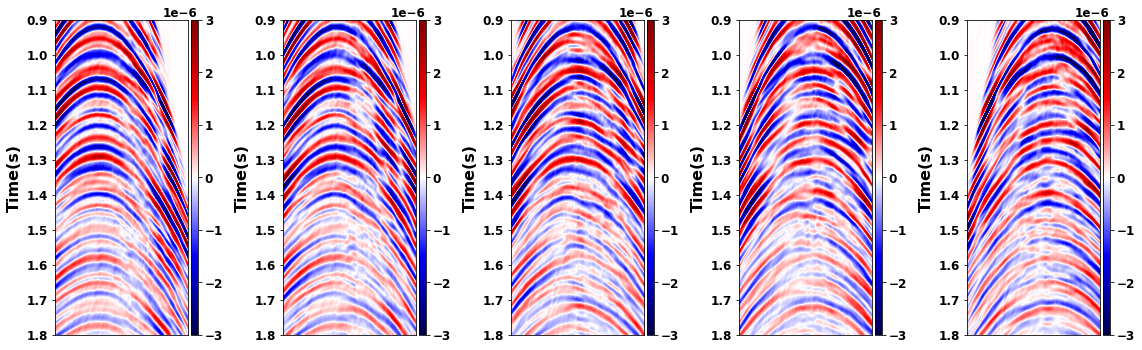

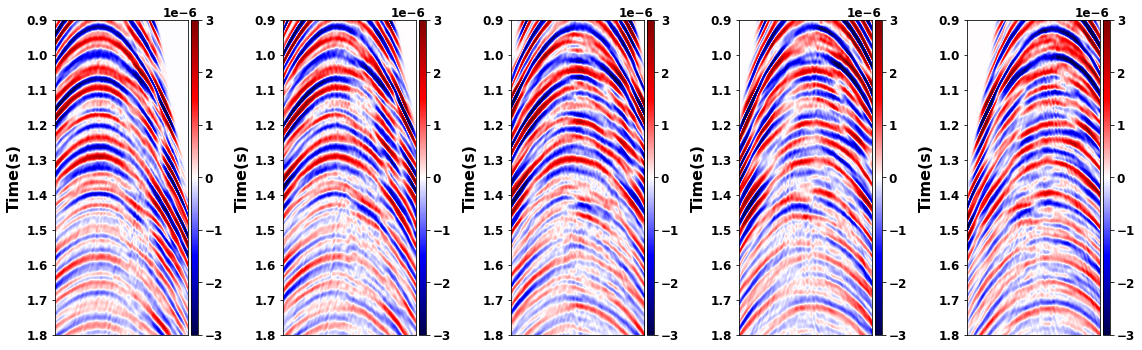

In [15]:
''' Shot differeces plots ''' 
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable


# Shot plotting 

# matplotlib.rc('image', cmap='gray')    
matplotlib.rc('image', cmap='seismic') 
font = {
'weight' : 'bold',
'size'   : 12}
matplotlib.rc('font', **font)
matplotlib.rcParams.update({'font.size': 12})
dt = 0.002
vmax = 3e-6
vmin = -vmax
# vmax = .15
# vmin = -.15
# vmin, vmax = np.percentile((Mclean-base).T,[2,98])




ncols=5
#-----------------------------------------------------------

def plot_differences(shot1,shot2,ncols,savedir,metric=True):

    # Measure metric window
    ti = 0
    tf = shot1.shape[-1]//2 
    print(f"metric window is [{start*dt}-{(start+tf)*dt}]")
    fig, ax = plt.subplots(1,ncols,figsize=(16,5))
    for i in range (ncols):
        nrms = NRMS(shot1[i],shot2[i],ti,tf)
        pred = predictability(shot1[i],shot2[i],ti,tf)
        
        im = ax[i].imshow(shot1[i].T - shot2[i].T ,
            vmin=vmin,vmax=vmax,extent=[0,2000,last*dt,start*dt])
        ax[i].axis("tight")
        ax[i].set_ylabel("Time(s)",fontsize=16,fontweight='bold')
        ax[i].axes.xaxis.set_visible(False)
        if metric: 
            ax[i].text(0.05,.85,
                f"NRMS {nrms:.2f} \nPred {pred:.2f}",size=16)

        divider = make_axes_locatable(ax[i])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(im, cax=cax, orientation='vertical')
    fig.tight_layout(pad=1.0)
    fig.savefig(savedir, bbox_inches='tight')


    
    
  
    
    
    
    
plot_differences(M,Pr-Pr.mean(axis=2, keepdims=True),
                ncols=5,savedir=f'./Fig/pred_diff{hyperpar}.png')

plot_differences(M, B,
                ncols=5,savedir=f'./Fig/before_diff{hyperpar}.png')

plot_differences(Mc,B,
                ncols=5,savedir=f'./Fig/target_diff{hyperpar}.png')

plot_differences(Pr-Pr.mean(axis=2, keepdims=True),
                 np.zeros_like(Pr),
                ncols=5,savedir=f'./Fig/pred_mon{hyperpar}.png',metric=False)

plot_differences(M, np.zeros_like(M),
                ncols=5,savedir=f'./Fig/mon{hyperpar}.png',metric=False)
